# Exercise 2.6

In [ ]:
import sys
print(sys.executable)


### 1. Import Libraries

In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("matplotlib imported ")


numpy: 1.26.4
pandas: 2.3.3
matplotlib imported 


In [ ]:
df = pd.read_csv("citibike_weather_2022.csv", low_memory=False)



In [86]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,date,PRCP,TMAX,TMIN,avg_temp
0,BFD29218AB271154,electric_bike,2022-01-21 13:13:43.392,2022-01-21 13:22:31.463,West End Ave & W 107 St,7650.05,Mt Morris Park W & W 120 St,7685.14,40.802117,-73.968181,40.804038,-73.945925,member,2022-01-21,0.0,-4.9,-9.3,-7.10
1,7C953F2FD7BE1302,classic_bike,2022-01-10 11:30:54.162,2022-01-10 11:41:43.422,4 Ave & 3 St,4028.04,Boerum Pl\t& Pacific St,4488.09,40.673746,-73.985649,40.688489,-73.991160,member,2022-01-10,0.0,5.6,-3.2,1.20
2,95893ABD40CED4B8,electric_bike,2022-01-26 10:52:43.096,2022-01-26 11:06:35.227,1 Ave & E 62 St,6753.08,5 Ave & E 29 St,6248.06,40.761227,-73.960940,40.745168,-73.986831,member,2022-01-26,0.0,-1.0,-6.0,-3.50
3,F853B50772137378,classic_bike,2022-01-03 08:35:48.247,2022-01-03 09:10:50.475,2 Ave & E 96 St,7338.02,5 Ave & E 29 St,6248.06,40.783964,-73.947167,40.745168,-73.986831,member,2022-01-03,0.0,3.9,-4.3,-0.20
4,7590ADF834797B4B,classic_bike,2022-01-22 14:14:23.043,2022-01-22 14:34:57.474,6 Ave & W 34 St,6364.10,5 Ave & E 29 St,6248.06,40.749640,-73.988050,40.745168,-73.986831,member,2022-01-22,0.0,-1.0,-9.9,-5.45


In [ ]:
df_sample = df.sample(frac=0.03, random_state=32)


In [88]:
df_sample.memory_usage(deep=True).sum() / 1024**2


22.783556938171387

In [90]:
df_sample.to_csv("citibike_weather_sample.csv", index=False)


### 2. Use Plotly to produce Bar chart

In [ ]:
# Find likely station-name columns
[c for c in df.columns if "station" in c.lower() and "start" in c.lower() and "name" in c.lower()]


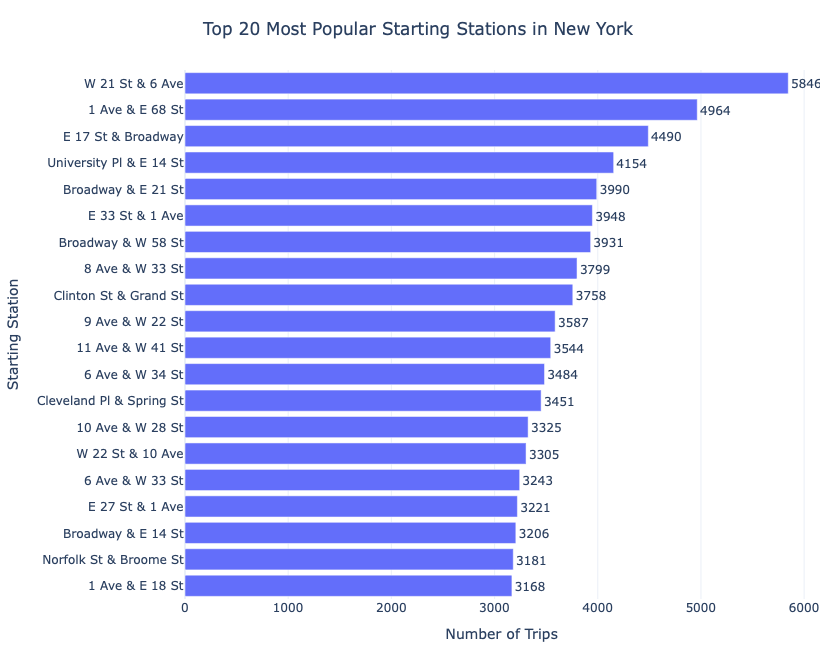

In [92]:
# Top stations bar chart(plotly)

import plotly.express as px

START_COL = "start_station_name"   # <-- replace with your column name
TOP_N = 20

top_stations = (
    df[START_COL]
    .value_counts()
    .head(TOP_N)
    .reset_index()
)
top_stations.columns = ["Station", "Trips"]

fig = px.bar(
    top_stations,
    x="Trips",
    y="Station",
    orientation="h",
    text="Trips",
    title=f"Top {TOP_N} Most Popular Starting Stations in New York"
)

fig.update_traces(
    textposition="outside",
    hovertemplate="<b>%{y}</b><br>Trips: %{x:,}<extra></extra>"
)

fig.update_layout(
    template="plotly_white",
    xaxis_title="Number of Trips",
    yaxis_title="Starting Station",
    title_x=0.5,
    height=650,
    margin=dict(l=20, r=20, t=70, b=30)
)

# Make sure the largest bar appears at the top
fig.update_yaxes(autorange="reversed")

fig.show()


In [ ]:
df.columns

### 3. Create a Dual axis line chart

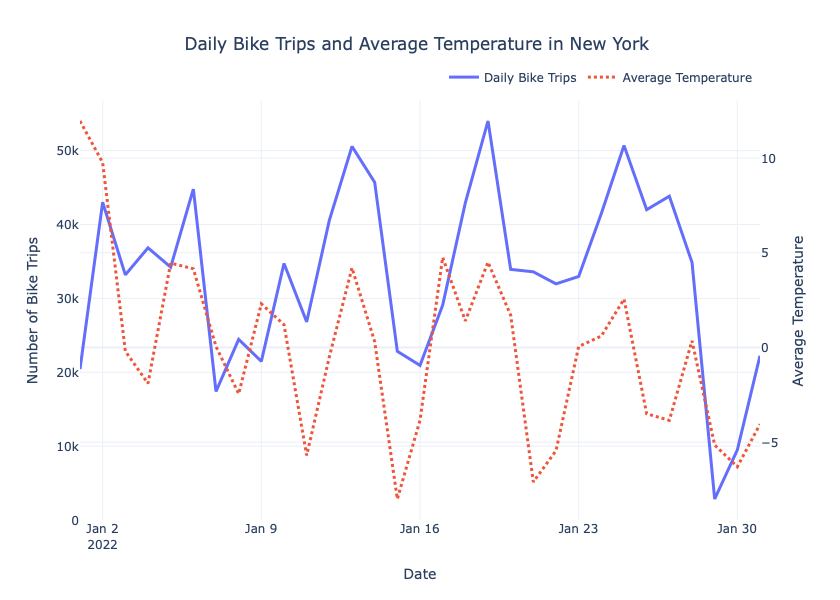

In [94]:
import pandas as pd
import plotly.graph_objects as go

# -----------------------------
# 1) Define correct columns
# -----------------------------
DATE_COL = "date"
TMAX_COL = "TMAX"
TMIN_COL = "TMIN"

# -----------------------------
# 2) Ensure correct data types
# -----------------------------
df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
df[TMAX_COL] = pd.to_numeric(df[TMAX_COL], errors="coerce")
df[TMIN_COL] = pd.to_numeric(df[TMIN_COL], errors="coerce")

# -----------------------------
# 3) Create average temperature
# -----------------------------
df["avg_temp"] = (df[TMAX_COL] + df[TMIN_COL]) / 2

# Remove rows with missing values
df_clean = df.dropna(subset=[DATE_COL, "avg_temp"]).copy()

# -----------------------------
# 4) Aggregate per day
# -----------------------------
daily_trips = (
    df_clean.groupby(DATE_COL)
            .size()
            .reset_index(name="trip_count")
)

daily_temp = (
    df_clean.groupby(DATE_COL)["avg_temp"]
            .mean()
            .reset_index(name="avg_temp")
)

daily = pd.merge(daily_trips, daily_temp, on=DATE_COL).sort_values(DATE_COL)

# -----------------------------
# 5) Dual-axis Plotly line chart
# -----------------------------
fig = go.Figure()

# Bike trips (left axis)
fig.add_trace(
    go.Scatter(
        x=daily[DATE_COL].to_numpy(),
        y=daily["trip_count"],
        name="Daily Bike Trips",
        mode="lines",
        line=dict(width=3),
        yaxis="y1",
        hovertemplate="Date: %{x|%Y-%m-%d}<br>Trips: %{y:,}<extra></extra>"
    )
)

# Temperature (right axis)
fig.add_trace(
    go.Scatter(
        x=daily[DATE_COL].to_numpy(),
        y=daily["avg_temp"],
        name="Average Temperature",
        mode="lines",
        line=dict(width=3, dash="dot"),
        yaxis="y2",
        hovertemplate="Date: %{x|%Y-%m-%d}<br>Avg Temp: %{y:.1f}<extra></extra>"
    )
)

fig.update_layout(
    title="Daily Bike Trips and Average Temperature in New York",
    title_x=0.5,
    template="plotly_white",
    height=600,
    hovermode="x unified",
    xaxis=dict(title="Date"),
    yaxis=dict(title="Number of Bike Trips"),
    yaxis2=dict(
        title="Average Temperature",
        overlaying="y",
        side="right"
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

fig.show()
